### Libraries & Imports

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime

In [ ]:
from src.phasenet.train import train
from src.phasenet.visualize import plot_stream_with_predictions, plot_fetched_waveforms
from src.phasenet.stream import make_stream, predict_stream, fetch_and_annotate_waveforms
from src.phasenet.get_model import get_phasenet_model, get_device
from src.phasenet.data_processing import load_data, split_data, create_generator, create_dataloader, create_augmentations
from src.constants import IQUIQUE_FOLDER_PATH

### Preparing model

In [3]:
device = get_device()
print("Using device:", device)

Using device: cuda


In [4]:
untrainded_model = get_phasenet_model()
pretrained_model = get_phasenet_model(pretrained_version="geofon")

c:\Users\barte\OneDrive\Pulpit\FO - projekt\FO--ml-seismic-classifier\.venv\Lib\site-packages\seisbench\models\base.py:899: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod

### Preparing data

In [ ]:
dataset = load_data(IQUIQUE_FOLDER_PATH)
train_ds, dev_ds, test_ds = split_data(dataset)

2026-01-11 19:19:02,404 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


In [6]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [7]:
untrained_augmentations = create_augmentations(phase_dict, untrainded_model)
prerained_augmentations = create_augmentations(phase_dict, pretrained_model)

In [8]:
train_generator_untrained = create_generator(train_ds, untrained_augmentations)
train_generator_pretrained = create_generator(train_ds, prerained_augmentations)

val_generator_untrained = create_generator(dev_ds, untrained_augmentations)
val_generator_pretrained = create_generator(dev_ds, prerained_augmentations)

In [9]:
train_loader_untrained = create_dataloader(train_generator_untrained, batch_size=256, num_workers=4)
train_loader_pretrained = create_dataloader(train_generator_pretrained, batch_size=256, num_workers=4)

val_loader_untrained = create_dataloader(val_generator_untrained, batch_size=256, num_workers=4)
val_loader_pretrained = create_dataloader(val_generator_pretrained, batch_size=256, num_workers=4)

### Preditions before training

In [10]:
random_index = np.random.randint(len(dataset))
print("Random index selected:", random_index)

Random index selected: 2876


In [11]:
stream = make_stream(dataset, random_index)
print(stream)

3 Trace(s) in Stream:
CX.PB02..EHZ | 2014-05-18T18:53:39.788392Z - 2014-05-18T18:56:11.208392Z | 100.0 Hz, 15143 samples
CX.PB02..EHN | 2014-05-18T18:53:39.788392Z - 2014-05-18T18:56:11.208392Z | 100.0 Hz, 15143 samples
CX.PB02..EHE | 2014-05-18T18:53:39.788392Z - 2014-05-18T18:56:11.208392Z | 100.0 Hz, 15143 samples


In [12]:
untrained_annotations = predict_stream(untrainded_model, stream)
pretrained_annotations = predict_stream(pretrained_model, stream)

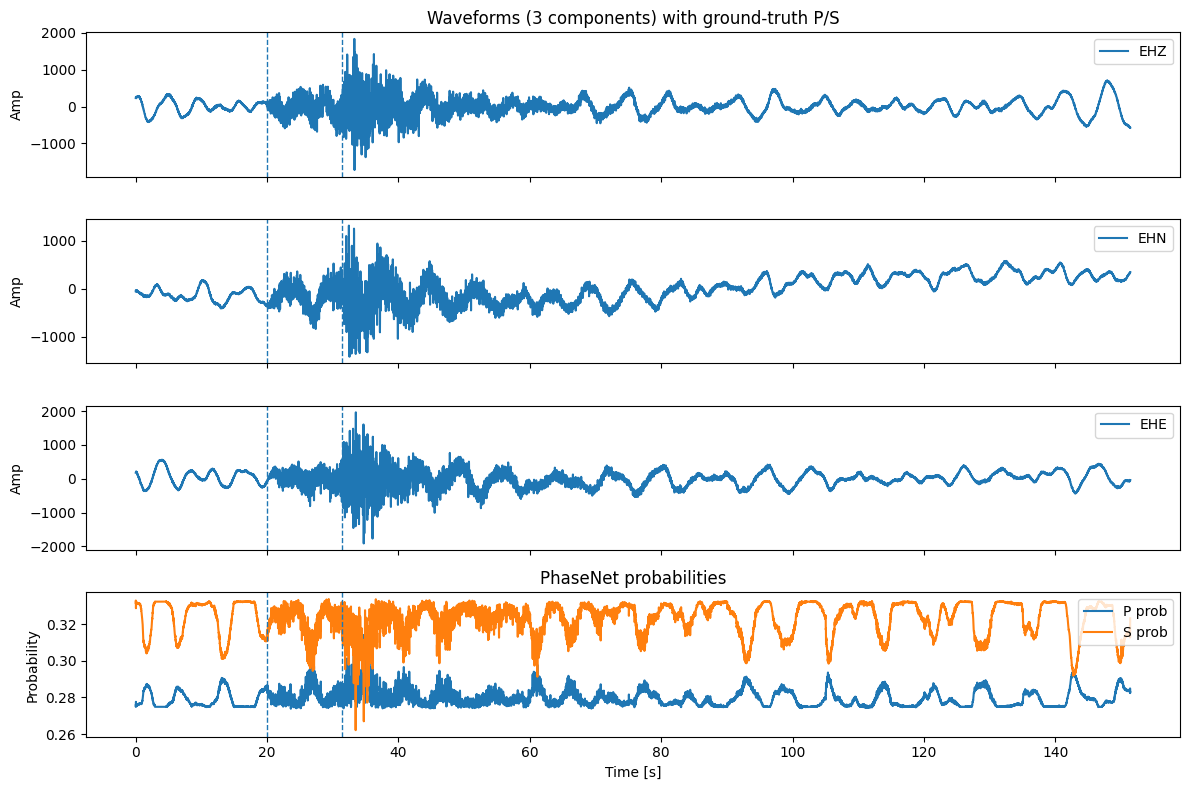

In [13]:
plot_stream_with_predictions(stream, untrained_annotations, metadata=dataset.metadata.iloc[random_index])

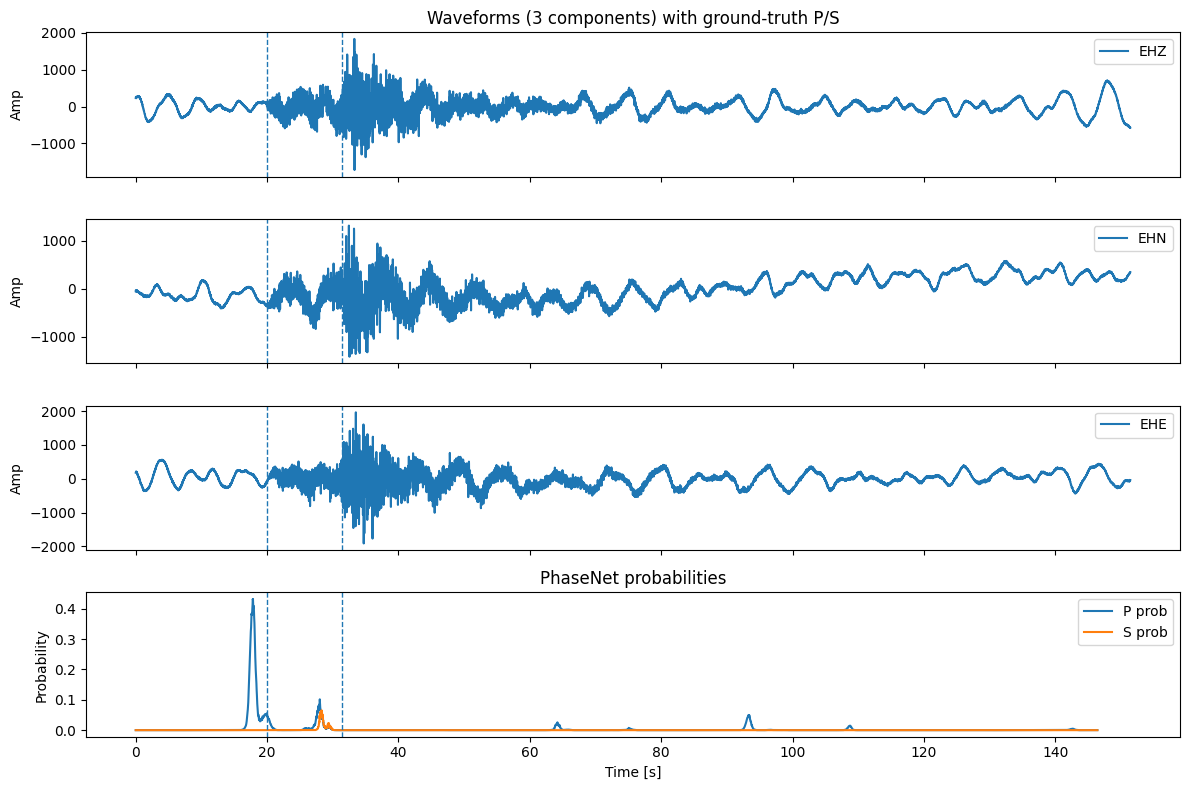

In [14]:
plot_stream_with_predictions(stream, pretrained_annotations, metadata=dataset.metadata.iloc[random_index])

### Training 

In [15]:
EPOCHS = 10
learning_rate = 1e-4
untrained_optimizer = torch.optim.Adam(untrainded_model.parameters(), lr=learning_rate)
pretrained_optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)

#### Training untrained model

In [17]:
train(untrainded_model, untrained_optimizer, train_loader_untrained, val_loader_untrained, epochs=EPOCHS, device=device)

Epoch 1
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


Train Loss: 1.143630 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Eval Loss: 1.110933 

Epoch 2
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Train Loss: 1.094005 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Eval Loss: 1.068599 

Epoch 3
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


Train Loss: 1.053047 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


Eval Loss: 1.032647 

Epoch 4
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


Train Loss: 1.017936 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Eval Loss: 1.003136 

Epoch 5
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Train Loss: 0.989918 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Eval Loss: 0.976098 

Epoch 6
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Train Loss: 0.964879 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Eval Loss: 0.951963 

Epoch 7
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Train Loss: 0.940697 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


Eval Loss: 0.928668 

Epoch 8
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Train Loss: 0.917286 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Eval Loss: 0.905288 

Epoch 9
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


Train Loss: 0.893747 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


Eval Loss: 0.881566 

Epoch 10
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Train Loss: 0.871061 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

Eval Loss: 0.859171 

Training complete!


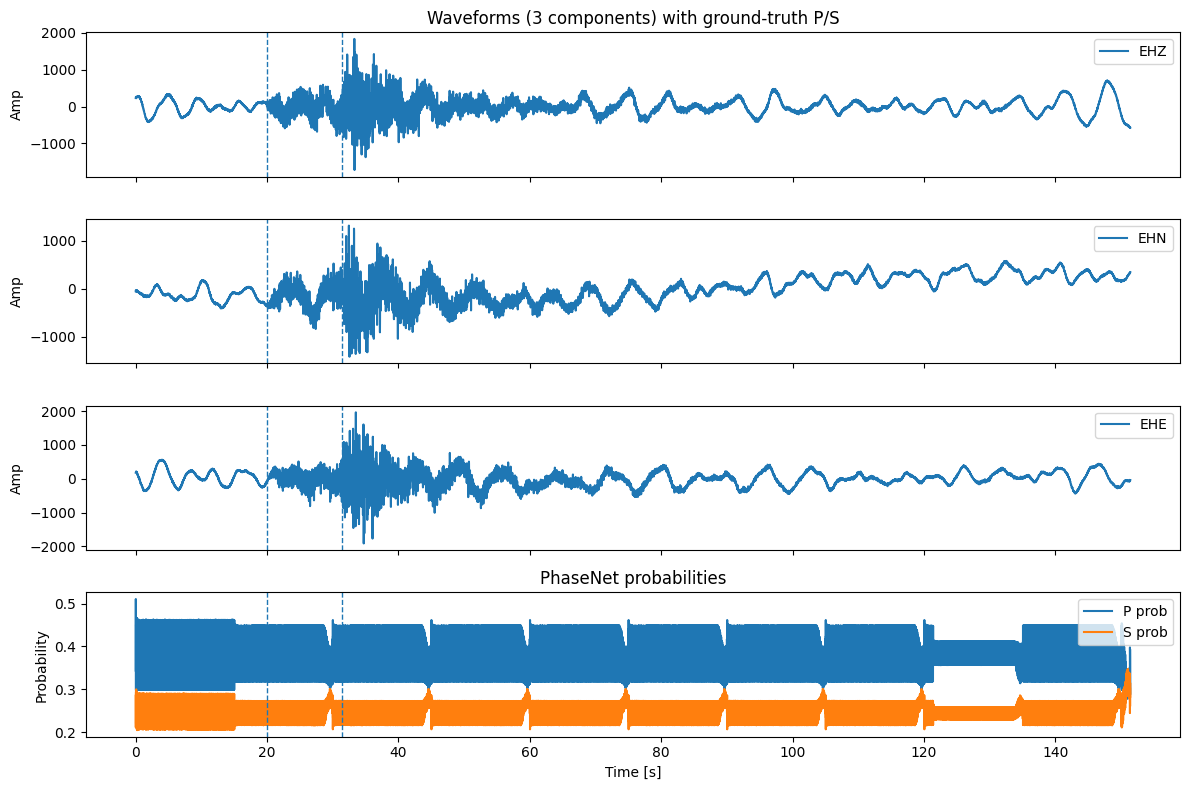

In [18]:
new_untrained_annotations = predict_stream(untrainded_model, stream)
plot_stream_with_predictions(stream, new_untrained_annotations, metadata=dataset.metadata.iloc[random_index])

#### Training pretrained model

In [19]:
train(pretrained_model, pretrained_optimizer, train_loader_pretrained, val_loader_pretrained, epochs=EPOCHS, device=device)

Epoch 1
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Train Loss: 0.191413 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Eval Loss: 0.151427 

Epoch 2
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Train Loss: 0.128214 



Evaluating Batches: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Eval Loss: 0.111982 

Epoch 3
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


Train Loss: 0.102507 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Eval Loss: 0.099030 

Epoch 4
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


Train Loss: 0.092260 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Eval Loss: 0.090421 

Epoch 5
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Train Loss: 0.087551 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Eval Loss: 0.085721 

Epoch 6
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Train Loss: 0.083320 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Eval Loss: 0.081693 

Epoch 7
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Train Loss: 0.080209 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Eval Loss: 0.080715 

Epoch 8
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Train Loss: 0.078709 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


Eval Loss: 0.080488 

Epoch 9
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Train Loss: 0.076656 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


Eval Loss: 0.076919 

Epoch 10
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Train Loss: 0.075368 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

Eval Loss: 0.076574 

Training complete!


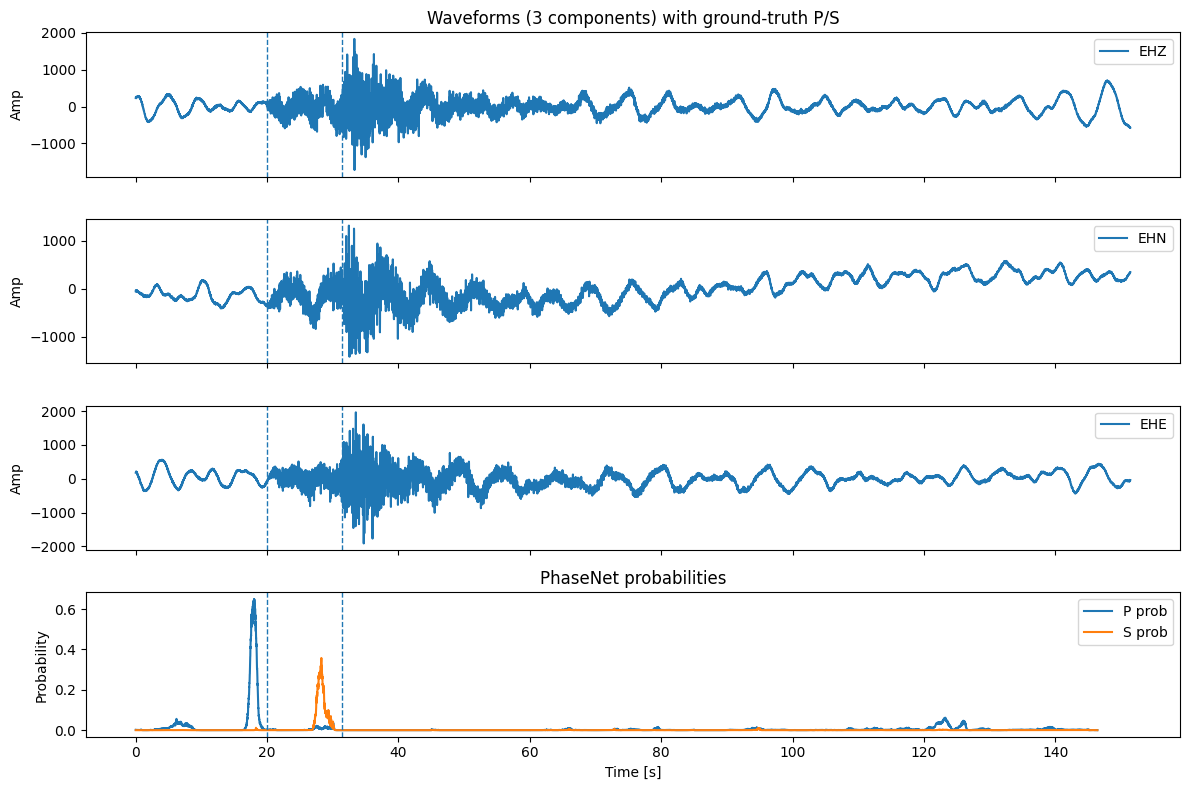

In [20]:
new_pretrained_annotations = predict_stream(pretrained_model, stream)
plot_stream_with_predictions(stream, new_pretrained_annotations, metadata=dataset.metadata.iloc[random_index])

#### Testing models on unseen data

In [37]:
t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream, annotations = fetch_and_annotate_waveforms(
    pretrained_model,
    provider="ETH",
    t=t,
    network="CH",
    station="EMING",
    location="*",
    channel="HH?",
    pre_s=30,
    post_s=50,
)

(0.0, 1.0)

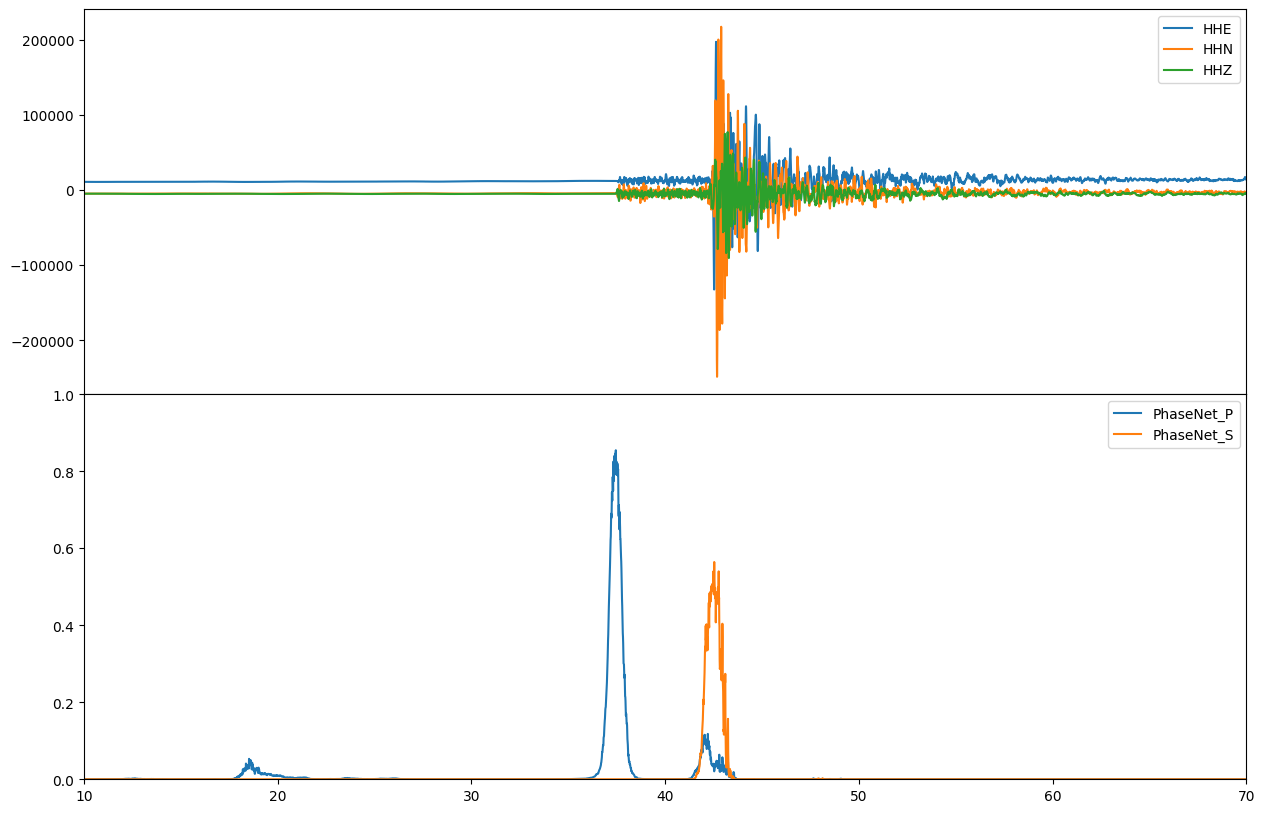

In [ ]:
plot_fetched_waveforms(stream, annotations)